In [1]:
import timeit
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import plotly.tools as pt
import plotly.io as pio
import chart_studio as cs
import plotly.graph_objs as go
import seaborn as sns
sns.set('paper')

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# transaction_df = pd.read_csv('gdrive/My Drive/ieee-fraud-detection/train_transaction.csv')

In [ ]:

# cat_cols = [column for column in transaction_df.columns if transaction_df[column].dtype == np.dtype('O') or transaction_df[column].value_counts().keys().shape[0] <= 2]

# dummies = pd.get_dummies(transaction_df[cat_cols].astype('category'),drop_first=True,dummy_na=True).astype('category')

# transaction_df = pd.concat([transaction_df.drop(cat_cols,axis=1), dummies],axis=1)

# null_cols = [column for column in transaction_df.columns if transaction_df[column].value_counts().keys().shape[0] == 1]

# transaction_df = transaction_df.drop(null_cols,axis=1)

# transaction_df = transaction_df.rename(columns={'isFraud_1.0':'isFraud'})

# card1 = transaction_df.card1.astype('category')

# transaction_df = pd.concat([transaction_df.drop('card1',axis=1),card1],axis=1)

In [ ]:
# remove_n = 589000
# drop_indices = np.random.choice(transaction_df.index,remove_n,replace=False)
# transaction_df = transaction_df.drop(drop_indices)

In [ ]:
# transaction_df.to_csv('gdrive/My Drive/ieee-fraud-detection/transaction_df_compressed.csv')

In [14]:
transaction_df = pd.read_csv('./ieee-fraud-detection/transaction_df_compressed.csv')

In [15]:
transaction_df = transaction_df.drop('Unnamed: 0',axis=1)

In [16]:
data_types = [transaction_df[column].dtype for column in transaction_df.columns]
data_types.reverse()
cat_start_idx = len(data_types) - data_types.index(np.dtype('float64'))

Number of NAN per variable barplot

In [ ]:
features = transaction_df.iloc[:,:cat_start_idx].isna().sum().keys()
missing = transaction_df.iloc[:,:cat_start_idx].isna().sum().values

layout = go.Layout(
autosize=True,
title='Missing Values per Feature',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure([go.Bar(x=features, y = missing,
                        marker_color = 'rgba(207, 114, 255, 0.5)')],layout=layout)
fig.show()

Class balance barplot

In [ ]:
not_fraud_count = transaction_df['isFraud'].value_counts().values[0]
fraud_count = transaction_df['isFraud'].value_counts().values[1]

layout = go.Layout(
autosize=True,
title='Class Imbalance',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure([go.Bar(x=['Fraud','Not Fraud'], y = [fraud_count/transaction_df.shape[0],
                                                      not_fraud_count/transaction_df.shape[0]], 
                        marker_color = 'rgba(255, 65, 54, 0.5)')], layout=layout)
fig.show()

Train-Test Split

In [5]:
X = np.array(transaction_df.drop(['isFraud','TransactionID'],axis=1))

In [6]:
Y = np.array(transaction_df['isFraud']).reshape((-1,))

In [7]:
del transaction_df

## Model Fitting for N-learn = 0.9

In [9]:
### Data capture lists: Train/Test Errors, Execution Time, Coefficients

logit_train_ls = []
logit_test_ls = []
logit_auc = []


logit_ridge_train_ls = []
logit_ridge_test_ls = []
logit_ridge_auc = []

logit_lasso_train_ls = []
logit_lasso_test_ls = []
logit_lasso_auc = []

rf_train_ls = []
rf_test_ls = []
rf_auc = []

svm_train_ls = []
svm_test_ls = []
svm_auc = []

logit_time = []
logit_ridge_time = []
logit_lasso_time = []
svm_time = []
rf_time = []

logit_ridge_cv_time = []
logit_lasso_cv_time = []
svm_cv_time = []

logit_coefs = []
lasso_coefs = []
ridge_coefs = []

In [10]:
### Parameter Grids for Logit & SVM GridSearch

svm_param_grid = {'C':np.linspace(10**-2, 10**2, 5),
                  'gamma':np.linspace(10**-2, 10**2, 5)}

param_grid_logit = {'C':np.linspace(1e-4,1,25)}


for _ in range(10):
    loop_start = timeit.default_timer()
    ### Data Split

    x_train09, x_test09, y_train09, y_test09 = train_test_split(X,Y, test_size = 0.1, stratify = Y)

    ### Preprocessing -- Missingness Imputation & Scaling

    imputer = SimpleImputer().fit(x_train09)
    x_train09 = imputer.transform(x_train09)
    x_test09 = imputer.transform(x_test09)

    scaler = StandardScaler().fit(x_train09)
    x_train09 = scaler.transform(x_train09)
    x_test09 = scaler.transform(x_test09)

    ### Sample Weights

    sample_weights = compute_sample_weight('balanced',y_train09)


    ### Logistic Regression

    logit = LogisticRegression(penalty = 'none', class_weight = 'balanced',n_jobs=-1,
                               solver = 'lbfgs')

    t_start = timeit.default_timer()
    logit.fit(x_train09,y_train09,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    logit_time.append(t_end-t_start)
    
    train_preds = logit.predict(x_train09)
    test_preds = logit.predict(x_test09)

    logit_train_ls.append(1-accuracy_score(y_train09,train_preds))
    logit_test_ls.append(1-accuracy_score(y_test09, test_preds))

    logit_auc.append(roc_auc_score(y_test09, test_preds))

    logit_coefs.append(logit.coef_)
    
    ### Logistic Ridge CV (L2 Penalty)


    ridge = LogisticRegression(penalty = 'l2', solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced')

    ridgeCV = GridSearchCV(ridge, param_grid_logit, cv = 10, n_jobs = -1)

    t_start = timeit.default_timer()
    ridgeCV.fit(x_train09, y_train09)
    t_end = timeit.default_timer()

    logit_ridge_cv_time.append(t_end-t_start)

    ridge = ridgeCV.best_estimator_

    t_start = timeit.default_timer()
    ridge.fit(x_train09, y_train09,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    logit_ridge_time.append(t_end-t_start)

    train_preds = ridge.predict(x_train09)
    test_preds = ridge.predict(x_test09)
    probs = ridge.predict_proba(x_test09)

    logit_ridge_train_ls.append(1-accuracy_score(y_train09, train_preds))
    logit_ridge_test_ls.append(1-accuracy_score(y_test09, test_preds))
    logit_ridge_auc.append(roc_auc_score(y_test09, probs[:,1]))
    
    ridge_coefs.append(ridge.coef_)

    ### Logistic Lasso CV (L1 Penalty)

    lasso = LogisticRegression(penalty = 'l1', solver = 'saga', n_jobs = -1, class_weight = 'balanced')

    lassoCV = GridSearchCV(lasso, param_grid_logit, cv = 10, n_jobs = -1)

    t_start = timeit.default_timer()
    lassoCV.fit(x_train09, y_train09)
    t_end = timeit.default_timer()

    logit_lasso_cv_time.append(t_end-t_start)

    lasso = lassoCV.best_estimator_

    t_start = timeit.default_timer()
    lasso.fit(x_train09, y_train09,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    logit_lasso_time.append(t_end-t_start)

    train_preds = lasso.predict(x_train09)
    test_preds = lasso.predict(x_test09)
    probs = lasso.predict_proba(x_test09)

    logit_lasso_train_ls.append(1-accuracy_score(y_train09, train_preds))
    logit_lasso_test_ls.append(1-accuracy_score(y_test09, test_preds))
    logit_lasso_auc.append(roc_auc_score(y_test09, probs[:,1]))
    
    lasso_coefs.append(lasso.coef_)

    ### Random Forest

    rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, class_weight = 'balanced')

    t_start = timeit.default_timer()
    rf.fit(x_train09, y_train09,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    rf_time.append(t_end-t_start)

    train_preds = rf.predict(x_train09)
    test_preds = rf.predict(x_test09)
    probs = rf.predict_proba(x_test09)

    rf_train_ls.append(1-accuracy_score(y_train09, train_preds))
    rf_test_ls.append(1-accuracy_score(y_test09, test_preds))
    rf_auc.append(roc_auc_score(y_test09, probs[:,1]))

    ### SVM Radial Kernel

    svm = SVC(kernel='rbf', probability=False, class_weight = 'balanced')

    svmCV = GridSearchCV(svm, param_grid = svm_param_grid, n_jobs = -1, cv = 10)

    t_start = timeit.default_timer()
    svmCV.fit(x_train09, y_train09)
    t_end = timeit.default_timer()

    svm_cv_time.append(t_end-t_start)

    svm = svmCV.best_estimator_

    t_start = timeit.default_timer()
    svm.fit(x_train09,y_train09,sample_weight = sample_weights)
    t_end = timeit.default_timer()

    svm_time.append(t_end-t_start)

    train_preds = svm.predict(x_train09)
    test_preds = svm.predict(x_test09)
    # probs = svm.predict_proba(x_test09)

    svm_train_ls.append(1-accuracy_score(y_train09,train_preds))
    svm_test_ls.append(1-accuracy_score(y_test09,test_preds))
    # svm_auc.append(roc_auc_score(y_test09, probs[:,1]))

    loop_end = timeit.default_timer()
    
    print(f'loop time is:{loop_end-loop_start}')

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:114.28897515700001


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:104.26106457999998


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:102.09316630999996


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:104.86377240299998
loop time is:103.45896445700004


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:104.70775641800003


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:102.97487818100001


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:105.43377272999999


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:104.92711539800007


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:105.33879207199993


## Model Fitting for N-learn = 0.5

In [11]:
### Data capture lists: Train/Test Errors, Execution Time, Coefficients

logit_train_ls05 = []
logit_test_ls05 = []
logit_auc05 = []


logit_ridge_train_ls05 = []
logit_ridge_test_ls05 = []
logit_ridge_auc05 = []

logit_lasso_train_ls05 = []
logit_lasso_test_ls05 = []
logit_lasso_auc05 = []

rf_train_ls05 = []
rf_test_ls05 = []
rf_auc05 = []

svm_train_ls05 = []
svm_test_ls05 = []
svm_auc05 = []

logit_time05 = []
logit_ridge_time05 = []
logit_lasso_time05 = []
svm_time05 = []
rf_time05 = []

logit_ridge_cv_time05 = []
logit_lasso_cv_time05 = []
svm_cv_time05 = []

logit_coefs05 = []
lasso_coefs05 = []
ridge_coefs05 = []

In [12]:
### Parameter Grids for Logit & SVM GridSearch

svm_param_grid = {'C':np.linspace(10**-2, 10**2, 5),
                  'gamma':np.linspace(10**-2, 10**2, 5)}

param_grid_logit = {'C':np.linspace(1e-4,1,25)}


for _ in range(10):
    loop_start = timeit.default_timer()
    ### Data Split

    x_train05, x_test05, y_train05, y_test05 = train_test_split(X,Y, test_size = 0.5, stratify = Y)

    ### Preprocessing -- Imputation & Scaling

    imputer = SimpleImputer().fit(x_train05)
    x_train05 = imputer.transform(x_train05)
    x_test05 = imputer.transform(x_test05)

    scaler = StandardScaler().fit(x_train05)
    x_train05 = scaler.transform(x_train05)
    x_test05 = scaler.transform(x_test05)

    ### Sample Weights

    sample_weights = compute_sample_weight('balanced',y_train05)


    ### Logistic Regression

    logit = LogisticRegression(penalty = 'none', class_weight = 'balanced',n_jobs=-1,
                               solver = 'lbfgs')

    t_start = timeit.default_timer()
    logit.fit(x_train05,y_train05,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    logit_time05.append(t_end-t_start)
    
    train_preds = logit.predict(x_train05)
    test_preds = logit.predict(x_test05)

    logit_train_ls05.append(1-accuracy_score(y_train05,train_preds))
    logit_test_ls05.append(1-accuracy_score(y_test05, test_preds))

    logit_auc05.append(roc_auc_score(y_test05, test_preds))

    logit_coefs05.append(logit.coef_)
    
    ### Logistic Ridge CV (L2 Penalty)


    ridge = LogisticRegression(penalty = 'l2', solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced')

    ridgeCV = GridSearchCV(ridge, param_grid_logit, cv = 10, n_jobs = -1)

    t_start = timeit.default_timer()
    ridgeCV.fit(x_train05, y_train05)
    t_end = timeit.default_timer()

    logit_ridge_cv_time05.append(t_end-t_start)

    ridge = ridgeCV.best_estimator_

    t_start = timeit.default_timer()
    ridge.fit(x_train05, y_train05,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    logit_ridge_time05.append(t_end-t_start)

    train_preds = ridge.predict(x_train05)
    test_preds = ridge.predict(x_test05)
    probs = ridge.predict_proba(x_test05)

    logit_ridge_train_ls05.append(1-accuracy_score(y_train05, train_preds))
    logit_ridge_test_ls05.append(1-accuracy_score(y_test05, test_preds))
    logit_ridge_auc05.append(roc_auc_score(y_test05, probs[:,1]))
    
    ridge_coefs05.append(ridge.coef_)

    ### Logistic Lasso CV (L1 Penalty)

    lasso = LogisticRegression(penalty = 'l1', solver = 'saga', n_jobs = -1, class_weight = 'balanced')

    lassoCV = GridSearchCV(lasso, param_grid_logit, cv = 10, n_jobs = -1)

    t_start = timeit.default_timer()
    lassoCV.fit(x_train05, y_train05)
    t_end = timeit.default_timer()

    logit_lasso_cv_time05.append(t_end-t_start)

    lasso = lassoCV.best_estimator_

    t_start = timeit.default_timer()
    lasso.fit(x_train05, y_train05,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    logit_lasso_time05.append(t_end-t_start)

    train_preds = lasso.predict(x_train05)
    test_preds = lasso.predict(x_test05)
    probs = lasso.predict_proba(x_test05)

    logit_lasso_train_ls05.append(1-accuracy_score(y_train05, train_preds))
    logit_lasso_test_ls05.append(1-accuracy_score(y_test05, test_preds))
    logit_lasso_auc05.append(roc_auc_score(y_test05, probs[:,1]))
    
    lasso_coefs05.append(lasso.coef_)

    ### Random Forest

    rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, class_weight = 'balanced')

    t_start = timeit.default_timer()
    rf.fit(x_train05, y_train05,sample_weight=sample_weights)
    t_end = timeit.default_timer()

    rf_time05.append(t_end-t_start)

    train_preds = rf.predict(x_train05)
    test_preds = rf.predict(x_test05)
    probs = rf.predict_proba(x_test05)

    rf_train_ls05.append(1-accuracy_score(y_train05, train_preds))
    rf_test_ls05.append(1-accuracy_score(y_test05, test_preds))
    rf_auc05.append(roc_auc_score(y_test05, probs[:,1]))

    ### SVM Radial Kernel

    svm = SVC(kernel='rbf', probability=False, class_weight = 'balanced')

    svmCV = GridSearchCV(svm, param_grid = svm_param_grid, n_jobs = -1, cv = 10)

    t_start = timeit.default_timer()
    svmCV.fit(x_train05, y_train05)
    t_end = timeit.default_timer()

    svm_cv_time05.append(t_end-t_start)

    svm = svmCV.best_estimator_

    t_start = timeit.default_timer()
    svm.fit(x_train05,y_train05,sample_weight = sample_weights)
    t_end = timeit.default_timer()

    svm_time05.append(t_end-t_start)

    train_preds = svm.predict(x_train05)
    test_preds = svm.predict(x_test05)
    # probs = svm.predict_proba(x_test05)

    svm_train_ls05.append(1-accuracy_score(y_train05,train_preds))
    svm_test_ls05.append(1-accuracy_score(y_test05,test_preds))
    # svm_auc05.append(roc_auc_score(y_test05, probs[:,1]))

    loop_end = timeit.default_timer()
    
    print(f'loop time is:{loop_end-loop_start}')

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.432788039000116


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.49523319600007


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.08476888599989


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.70024355299984


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.385791831999995


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.266713896000056


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:42.18692732699992


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.73286032399983


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.00458926200008


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



loop time is:41.87628771300001


## Cross Validation Experiments/Plots

In [222]:

x_data = ['Logit Train', 'Logit Test', 'Ridge Train', 'Ridge Test',
          'Lasso Train', 'Lasso Test', 'Random Forest Train', 'Random Forest Test',
          'SVM Train', 'SVM Test']


y_data = [logit_train_ls, logit_test_ls,
         logit_ridge_train_ls, logit_ridge_test_ls,
         logit_lasso_train_ls, logit_lasso_test_ls,
         rf_train_ls, rf_test_ls, svm_train_ls, svm_test_ls]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 
          'rgba(44, 160, 101, 0.5)','rgba(255, 65, 54, 0.5)',
          'rgba(207, 114, 255, 0.5)','rgba(127, 96, 0, 0.5)',
          'rgba(93, 164, 214, 0.5)','rgba(255, 144, 14, 0.5)',
           'rgba(44, 160, 101, 0.5)','rgba(255, 65, 54, 0.5)'] 

traces = []

In [223]:
for xd, yd, clrs in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=clrs,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))
        
layout = go.Layout(
autosize=True,
height=800,
title='Train-Test Errors for 5 Classification Methods (N-learn=0.9)',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(data=traces, layout=layout)

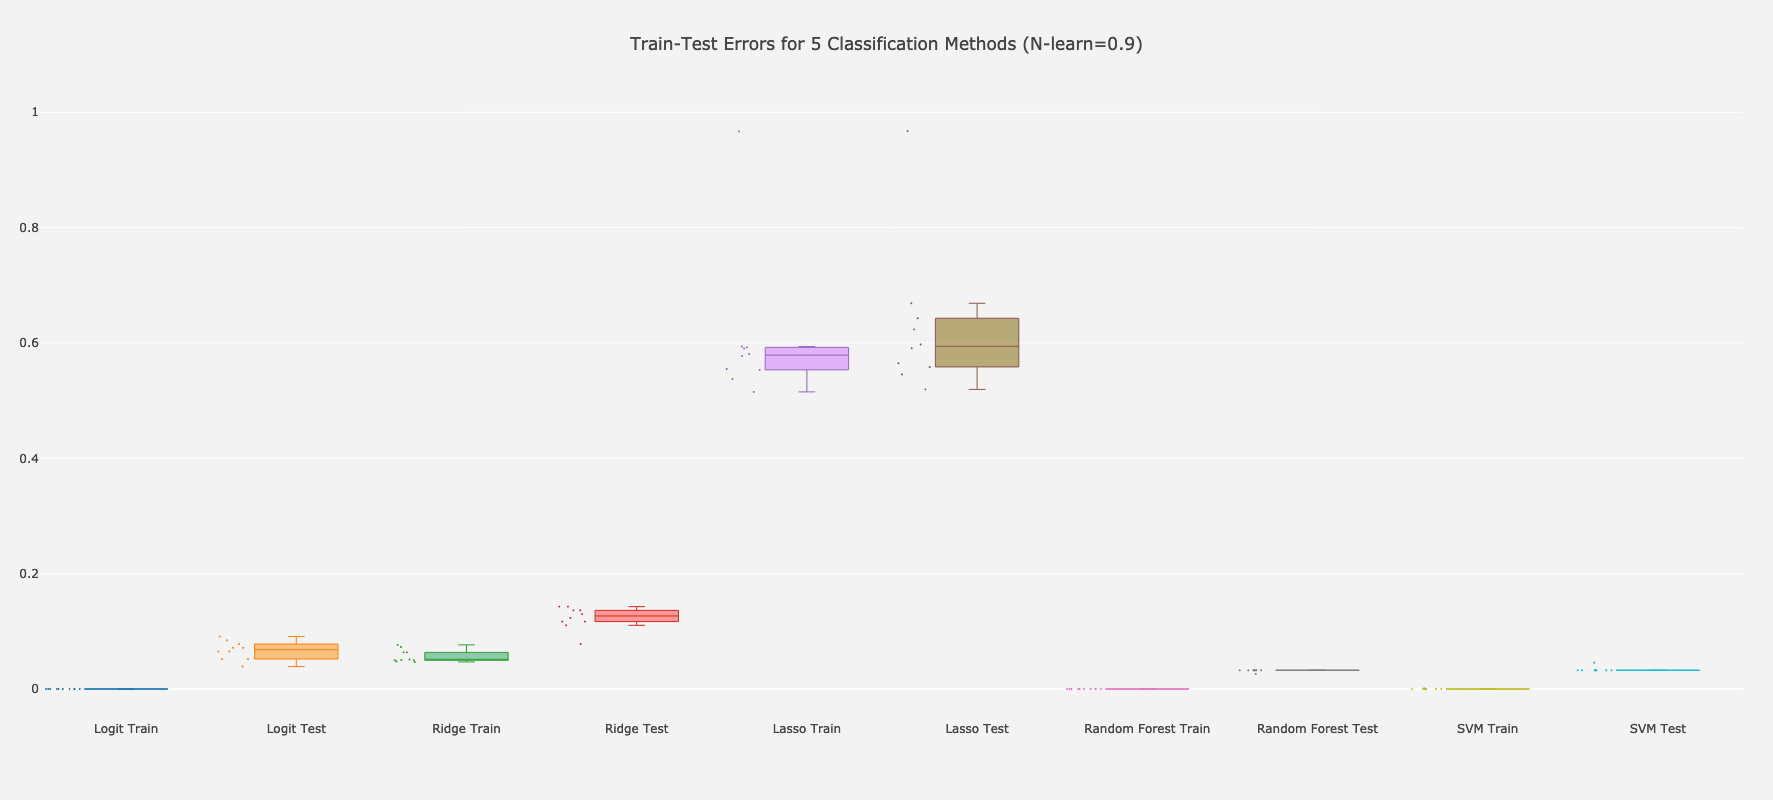

In [224]:
fig.show()
#pt.set_credentials_file(username='mdrozdov', api_key='lIJzsy13FVNFbyw4I9bS')
#py.iplot(fig)

In [225]:

x_data = ['Logit Train', 'Logit Test', 'Ridge Train', 'Ridge Test',
          'Lasso Train', 'Lasso Test', 'Random Forest Train', 'Random Forest Test',
          'SVM Train', 'SVM Test']


y_data = [logit_train_ls05, logit_test_ls05,
         logit_ridge_train_ls05, logit_ridge_test_ls05,
         logit_lasso_train_ls05, logit_lasso_test_ls05,
         rf_train_ls05, rf_test_ls05, svm_train_ls05, svm_test_ls05]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 
          'rgba(44, 160, 101, 0.5)','rgba(255, 65, 54, 0.5)',
          'rgba(207, 114, 255, 0.5)','rgba(127, 96, 0, 0.5)',
          'rgba(93, 164, 214, 0.5)','rgba(255, 144, 14, 0.5)',
           'rgba(44, 160, 101, 0.5)','rgba(255, 65, 54, 0.5)'] 

traces = []

In [226]:
for xd, yd, clrs in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=clrs,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))
        
layout = go.Layout(
autosize=True,
height=800,
title='Train-Test Errors for 5 Classification Methods (N-learn=0.5)',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(data=traces, layout=layout)

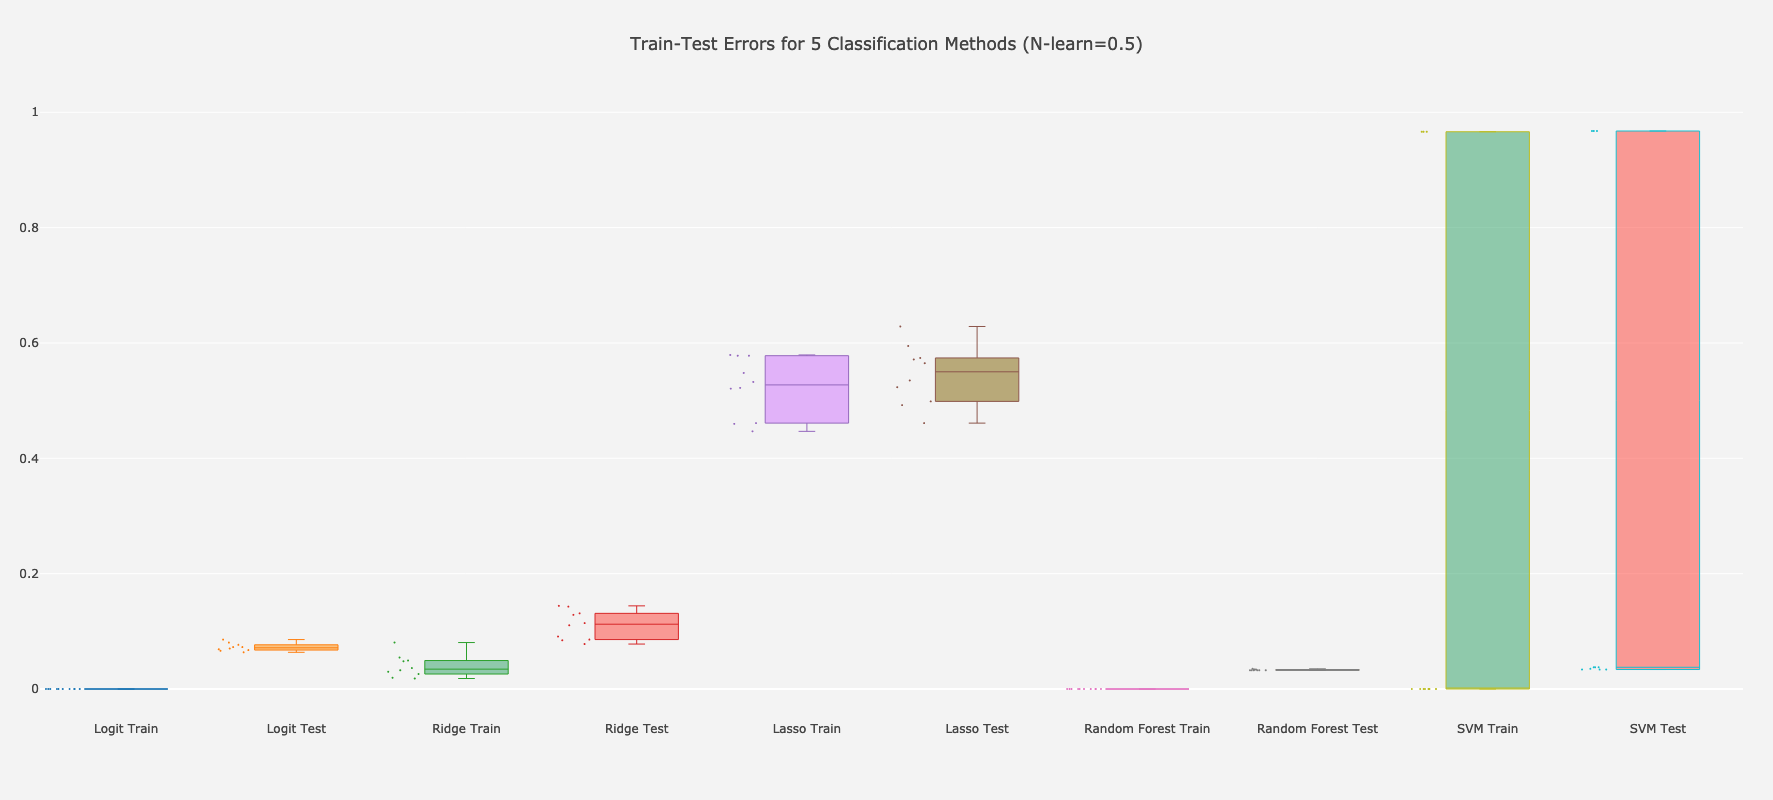

In [227]:
fig.show()
#pt.set_credentials_file(username='mdrozdov', api_key='lIJzsy13FVNFbyw4I9bS')
#py.iplot(fig)

In [196]:
coefs = list(zip(*[coef[0].tolist() for coef in logit_coefs]))
coefs = list(map(lambda x: list(map(lambda y: abs(y),x)), coefs))
coefs = [np.mean(coef) for coef in coefs]

cols = transaction_df.drop(['isFraud','TransactionID'],axis=1).columns

coefs = sorted(list(zip(coefs, cols)), key = lambda x: x[0], reverse = True)

abs_avg_coefs = [item[0] for item in coefs]
cols = [item[1] for item in coefs]

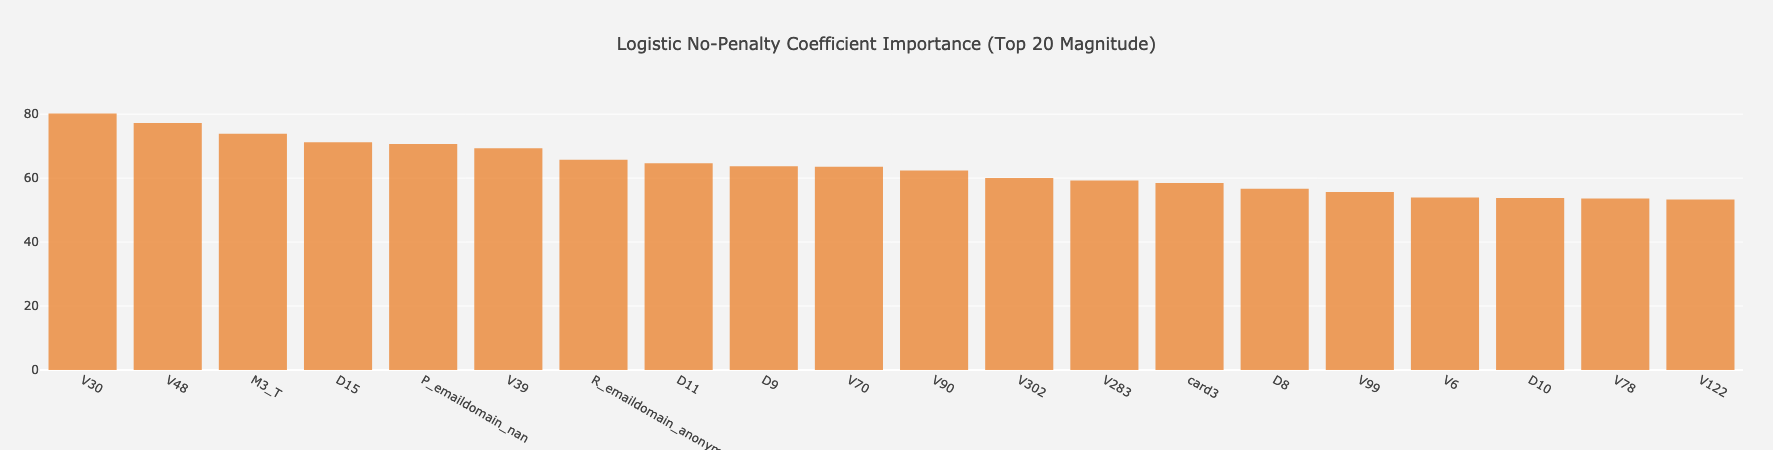

In [197]:
layout = go.Layout(
autosize=True,
title='Logistic No-Penalty Coefficient Importance (Top 20 Magnitude)',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(layout=layout)

fig.add_trace(go.Bar(x = cols[:20], y = abs_avg_coefs[:20], marker_color = 'rgba(234, 131, 46, 0.77)'))

fig.show()

In [198]:
coefs = list(zip(*[coef[0].tolist() for coef in lasso_coefs]))
coefs = list(map(lambda x: list(map(lambda y: abs(y),x)), coefs))
coefs = [np.mean(coef) for coef in coefs]

cols = transaction_df.drop(['isFraud','TransactionID'],axis=1).columns

coefs = sorted(list(zip(coefs, cols)), key = lambda x: x[0], reverse = True)

abs_avg_coefs = [item[0] for item in coefs]
cols = [item[1] for item in coefs]

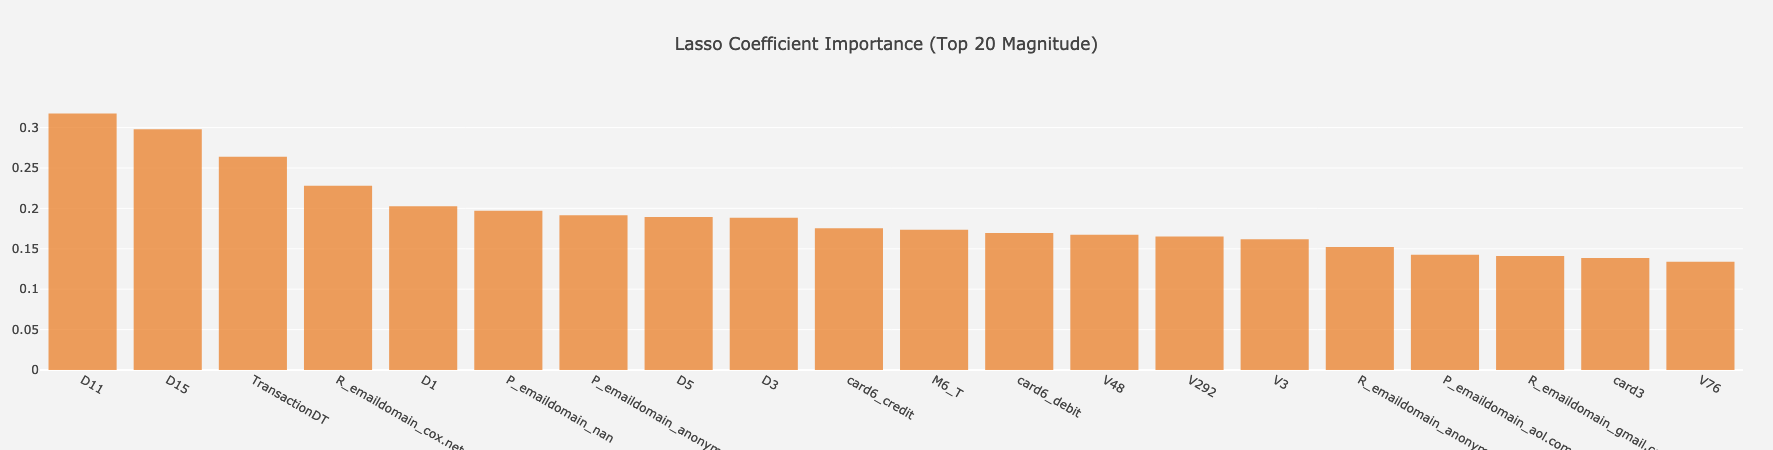

In [199]:
layout = go.Layout(
autosize=True,
title='Lasso Coefficient Importance (Top 20 Magnitude)',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(layout=layout)

fig.add_trace(go.Bar(x = cols[:20], y = abs_avg_coefs[:20], marker_color = 'rgba(234, 131, 46, 0.77)'))

fig.show()

In [200]:
coefs = list(zip(*[coef[0].tolist() for coef in ridge_coefs]))
coefs = list(map(lambda x: list(map(lambda y: abs(y),x)), coefs))
coefs = [np.mean(coef) for coef in coefs]

cols = transaction_df.drop(['isFraud','TransactionID'],axis=1).columns

coefs = sorted(list(zip(coefs, cols)), key = lambda x: x[0], reverse = True)

abs_avg_coefs = [item[0] for item in coefs]
cols = [item[1] for item in coefs]

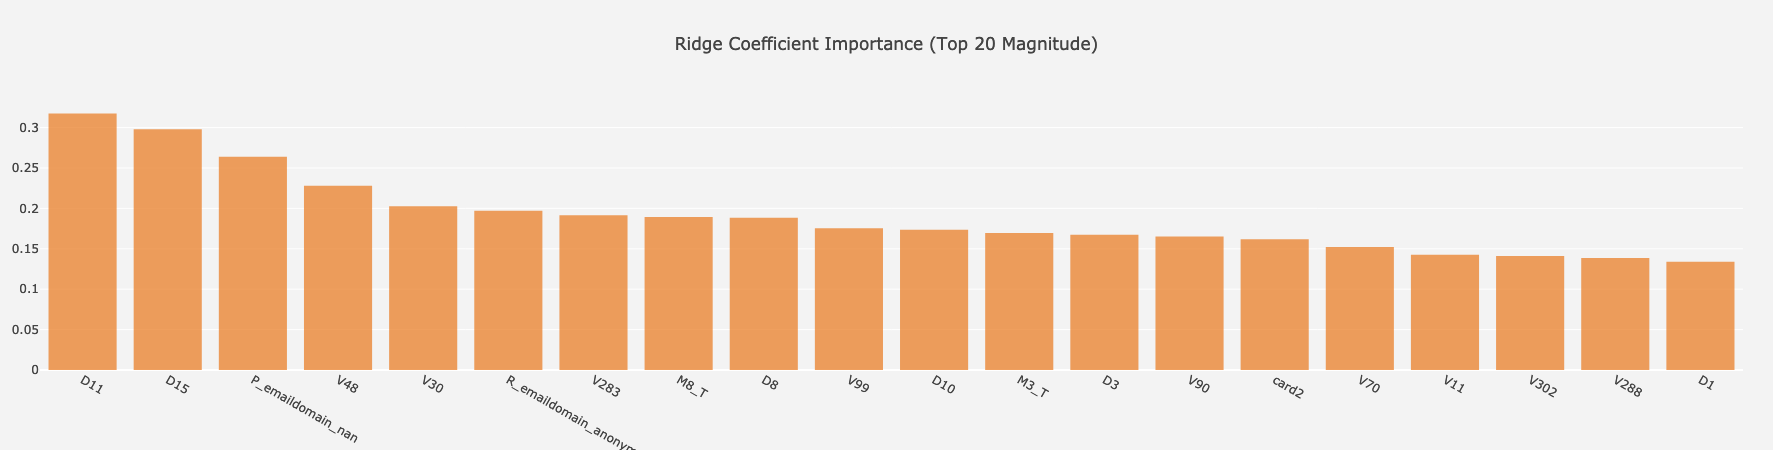

In [201]:
layout = go.Layout(
autosize=True,
title='Ridge Coefficient Importance (Top 20 Magnitude)',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(layout=layout)

fig.add_trace(go.Bar(x = cols[:20], y = abs_coefs[:20], marker_color = 'rgba(234, 131, 46, 0.77)'))

fig.show()

In [145]:

coefs = []
errors = []

sample_weights2 = compute_sample_weight('balanced',y_train09)

for alpha in np.linspace(1e-1,1e+3,25):
    ridge = LogisticRegression(penalty = 'l2', solver = 'saga', n_jobs = -1, class_weight = 'balanced', C = alpha)
    ridge.fit(x_train09, y_train09, sample_weight = sample_weights2)

    coefs.append(np.abs(ridge.coef_))
    errors.append(1-accuracy_score(y_test09,ridge.predict(x_test09)))

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [146]:
betas = list(zip(*[coef[0].tolist() for coef in coefs]))

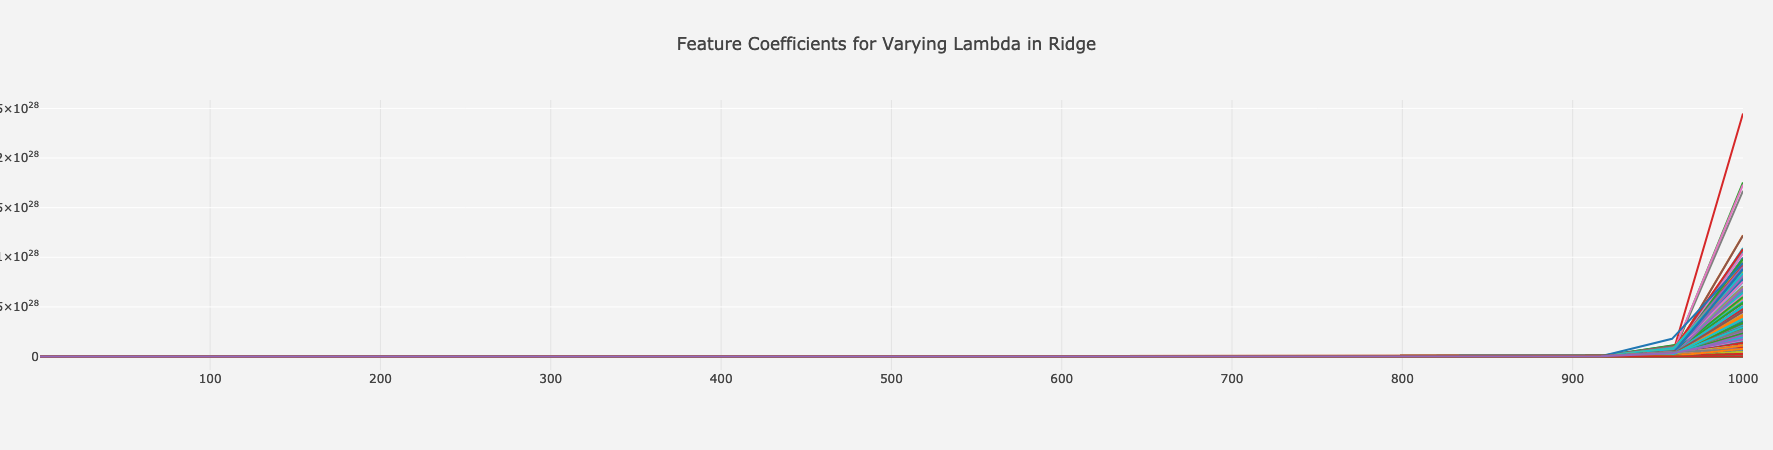

In [147]:

traces = []

for beta in betas:
  traces.append(go.Scatter(x = np.linspace(1e-1,1e+3,25).tolist(),
                            y = beta,
                            mode = 'lines'))

layout = go.Layout(
autosize=True,
title='Feature Coefficients for Varying Lambda in Ridge',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(data=traces,layout=layout)

fig.show()

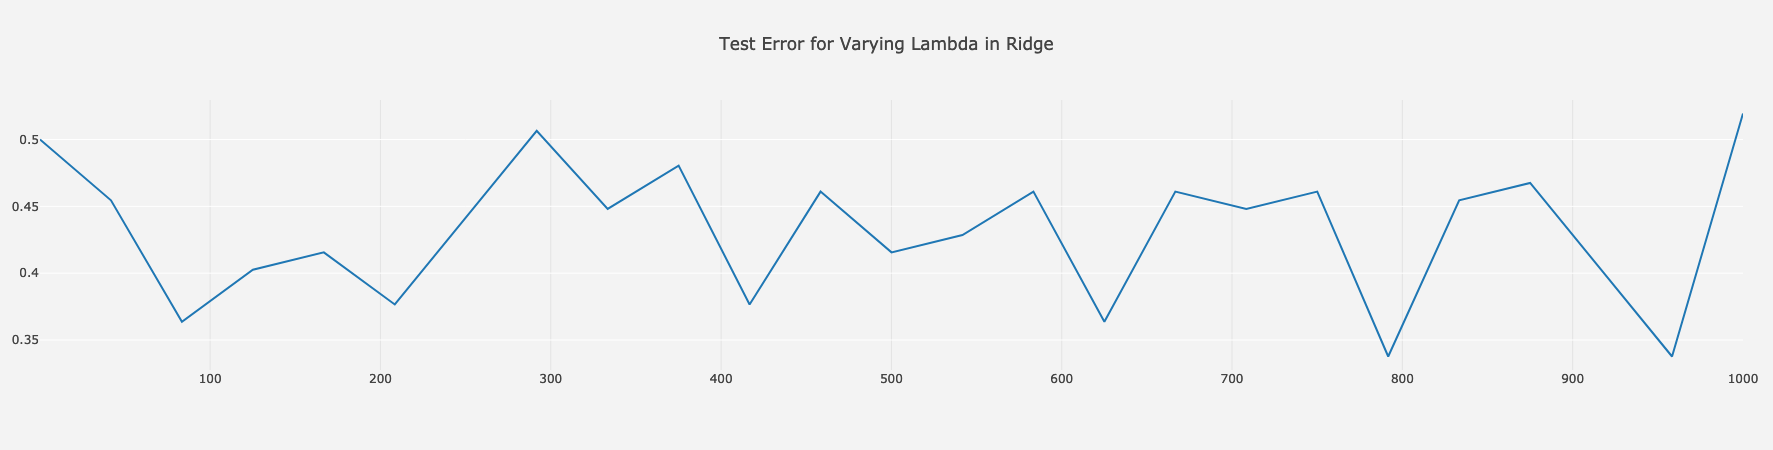

In [152]:

traces = []


traces.append(go.Scatter(x = np.linspace(1e-1,1e+3,25).tolist(),
                            y = errors,
                            mode = 'lines'))

layout = go.Layout(
autosize=True,
title='Test Error for Varying Lambda in Ridge',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(data=traces,layout=layout)

fig.show()

In [148]:

coefs2 = []
errors2 = []

for alpha in np.linspace(1e-1,1e+3,25):
    lasso = LogisticRegression(penalty = 'l1', solver = 'saga', n_jobs = -1, class_weight = 'balanced', C = alpha)
    lasso.fit(x_train09, y_train09, sample_weight = sample_weights2)

    coefs2.append(np.abs(lasso.coef_))
    errors2.append(1-accuracy_score(y_test09,lasso.predict(x_test09)))

In [149]:
betas = list(zip(*[coef[0].tolist() for coef in coefs2]))

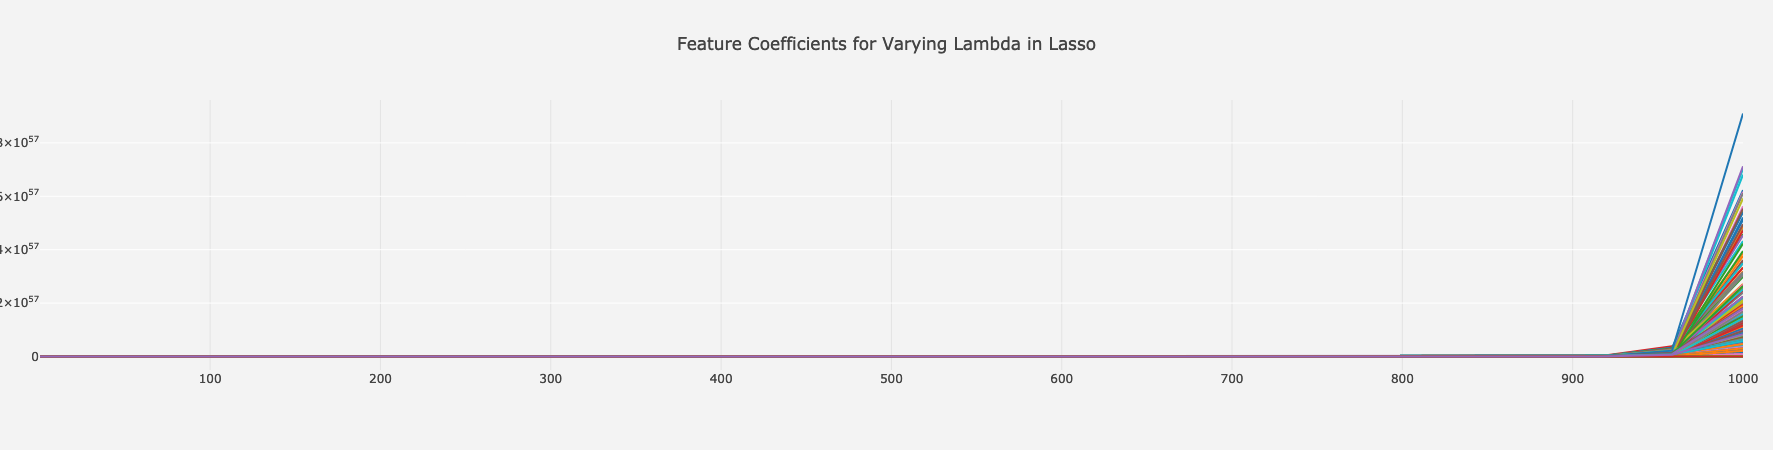

In [150]:

traces = []

for beta in betas:
  traces.append(go.Scatter(x = np.linspace(1e-1,1e+3,25).tolist(),
                            y = beta,
                            mode = 'lines'))

layout = go.Layout(
autosize=True,
title='Feature Coefficients for Varying Lambda in Lasso',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(data=traces,layout=layout)

fig.show()

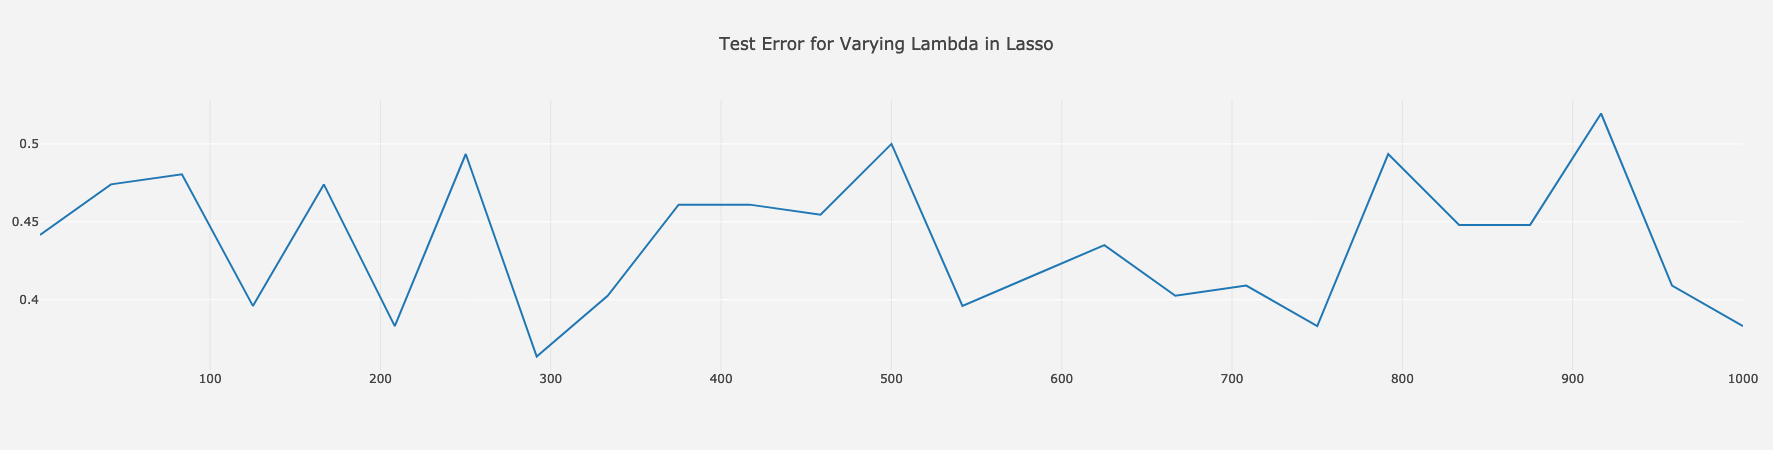

In [153]:

traces = []


traces.append(go.Scatter(x = np.linspace(1e-1,1e+3,25).tolist(),
                            y = errors2,
                            mode = 'lines'))

layout = go.Layout(
autosize=True,
title='Test Error for Varying Lambda in Lasso',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(data=traces,layout=layout)

fig.show()

In [180]:
sample_weights3 = compute_sample_weight('balanced',y_train05)

errors3 = []

for C in np.linspace(10**-2, 10**2, 5):
    for gamma in np.linspace(10**-2, 10**2, 5):
        svm = SVC(kernel='rbf', probability=False, class_weight = 'balanced',C = C, gamma = gamma)
        svm.fit(x_train05, y_train05, sample_weight = sample_weights3)
        
        errors3.append(1-accuracy_score(y_test05, svm.predict(x_test05)))
        


In [185]:
# errors3 = np.array(errors3).reshape((5,5))

In [189]:
np.linspace(10**-2, 10**2, 5).reshape(5,1)

array([[1.00000e-02],
       [2.50075e+01],
       [5.00050e+01],
       [7.50025e+01],
       [1.00000e+02]])

In [184]:
errors3

[0.9675324675324676,
 0.9675324675324676,
 0.9675324675324676,
 0.9675324675324676,
 0.9675324675324676,
 0.03766233766233762,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242,
 0.036363636363636376,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242,
 0.036363636363636376,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242,
 0.036363636363636376,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242,
 0.03246753246753242]

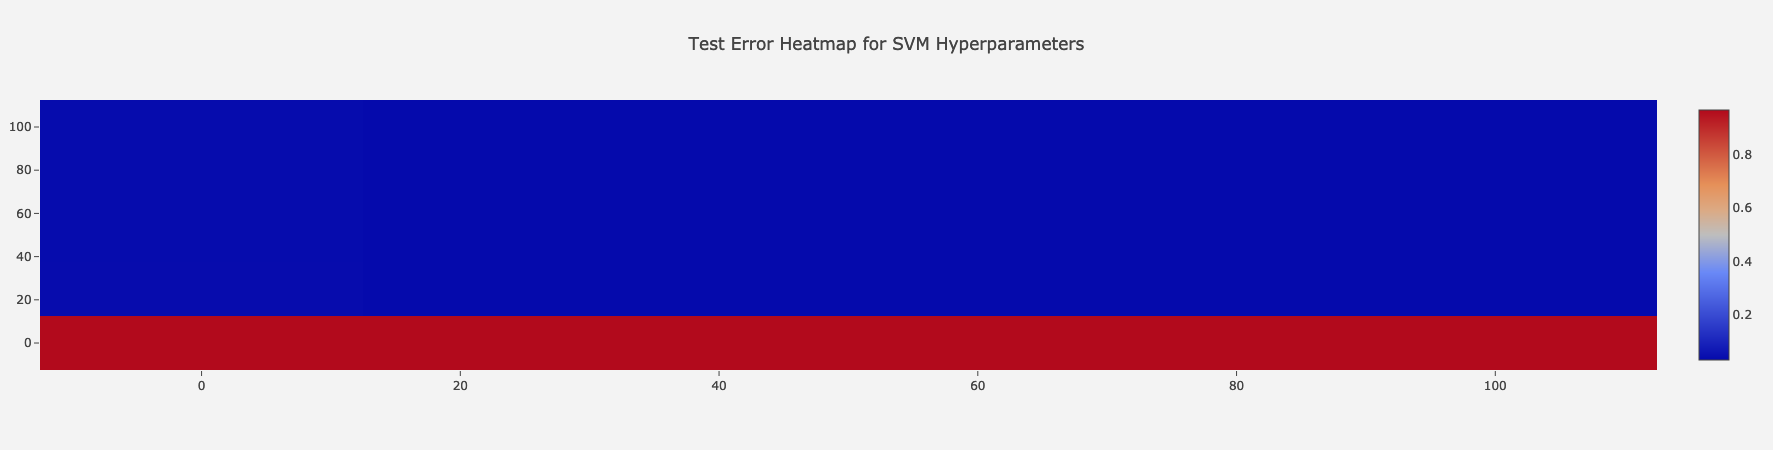

In [195]:
layout = go.Layout(
autosize=True,
title='Test Error Heatmap for SVM Hyperparameters',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Heatmap(x = np.linspace(10**-2, 10**2, 5),
                        y = np.linspace(10**-2, 10**2, 5),
                        z = np.array(errors3).reshape(5,5)))

fig.show()

In [228]:

x_data = ['Logit','Ridge CV',
          'Lasso CV', 'Random Forest',
          'SVM CV']


y_data = [logit_time, logit_ridge_cv_time,
         logit_lasso_cv_time, rf_time, svm_cv_time]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 
          'rgba(44, 160, 101, 0.5)','rgba(255, 65, 54, 0.5)',
          'rgba(207, 114, 255, 0.5)'] 

traces = []

In [229]:
for xd, yd, clrs in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=clrs,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))
        
layout = go.Layout(
autosize=True,
height=800,
title='Compute Time for 5 Classification Methods (N-learn=0.9)',
yaxis=dict(
    autorange=True,
    showgrid=True,
    zeroline=True,
    dtick=0,
    gridcolor='rgb(255, 255, 255)',
    gridwidth=1,
    zerolinecolor='rgb(255, 255, 255)',
    zerolinewidth=2,
),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)

fig = go.Figure(data=traces, layout=layout)

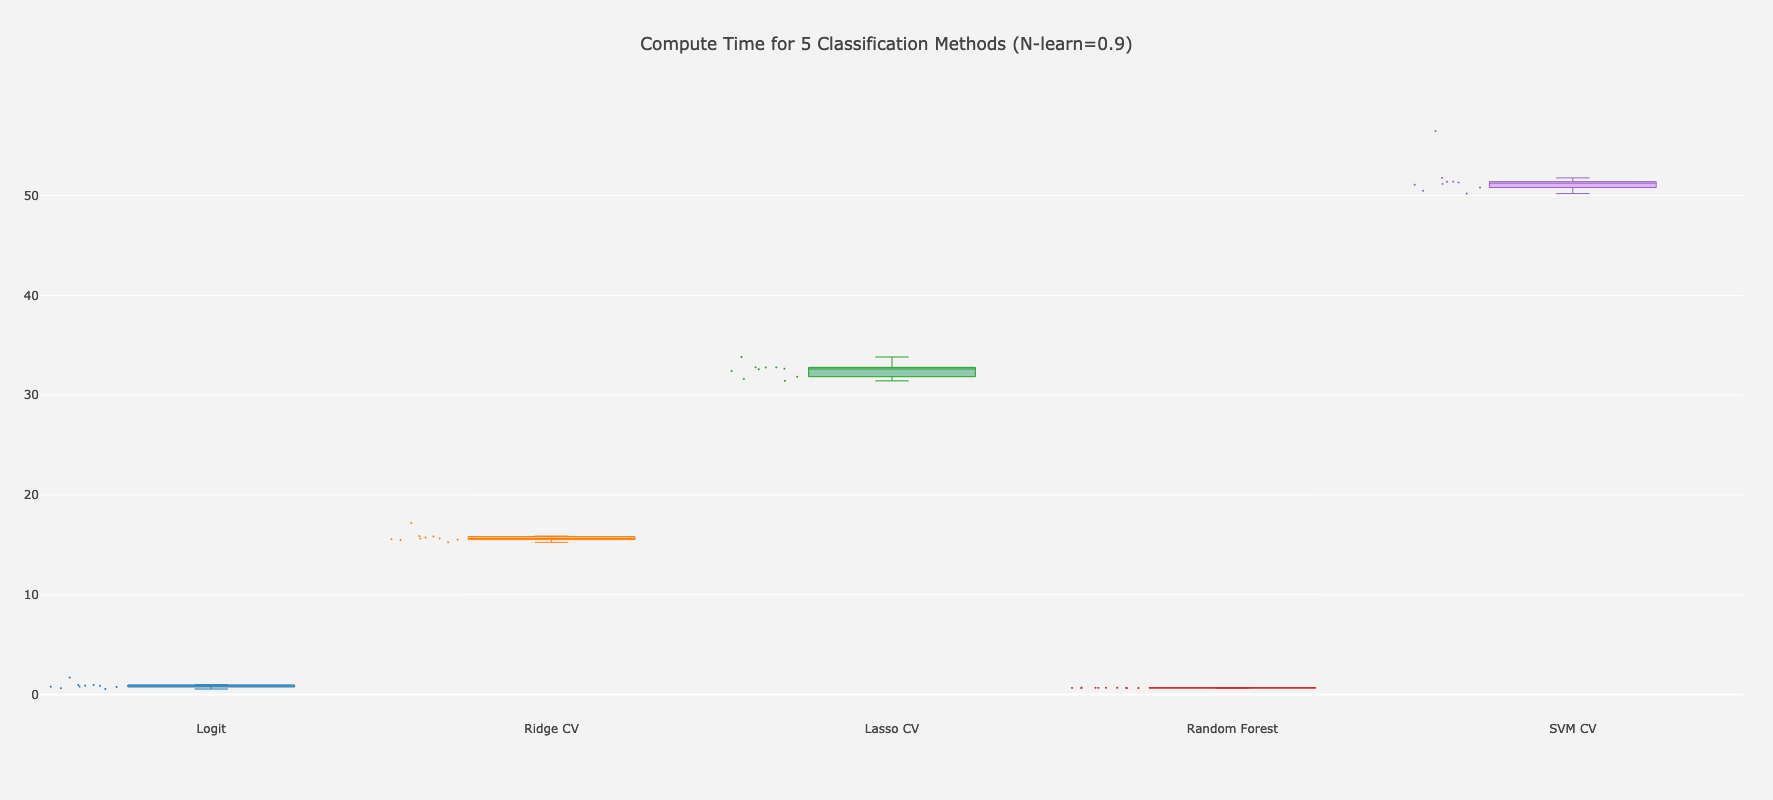

In [230]:
fig.show()
#pt.set_credentials_file(username='mdrozdov', api_key='lIJzsy13FVNFbyw4I9bS')
#py.iplot(fig)